In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from metricnew import metricx
from colormetric import colormetricx

from feature_vae import FeatureVAE
from FVAE_helper import GradientReversalLayer, SimpleRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from encoders import USEEncode, CLIPEncode, W2VEncode
from itertools import product

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/Users/thomas/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


device(type='cpu')

In [2]:
non_given_dims = 50

rgb_supervise = True
rgb_supervise_start_epoch = 100
rgb_weak_supervise_prop = 0.1
rgb_pred_pretrain_epochs = 20

# beta for temperature sampling (by epoch). set to 0 to disable
rgb_temp_beta = 0.98
rgb_main_lr = 1e-5
rgb_lambda = 5
    
    
adversarial_supervise = False
# 20 or 30, depending
adversarial_lambda = 50
adversarial_target_language = True
adversarial_extra_train = 5

extra_reducer = False
extra_reducer_dim = 4

encoder_class = USEEncode
encoder_prompt = 'a {} colored shape'
encoder_model = None

beta = 1.0

num_epochs = 50
batch_size = 64
gradient_accumulation_steps = 1
lr = 1e-3
grad_clip = 1.0

updates_per_epoch = 1
num_displays = 3

In [3]:
rand_state = 420

torch.manual_seed(rand_state)
np.random.seed(rand_state)

In [4]:
name = 'shapes'
if encoder_class is W2VEncode:
    name = 'shapes_w2v'

In [5]:
resize = transforms.Resize(64)
shapes = resize(torch.load(f'{name}.pt').permute(0, 3, 1, 2) / 255)
del resize
shapes.shape

torch.Size([20000, 3, 64, 64])

In [6]:
shapes_meta = pd.read_csv(f'{name}.csv')
shapes_meta.head()

,shape,color,r,g,b,wscale,hscale,rotation,skew,xcenter,ycenter,hatch,shadow
0,pentagon,deep teal,0.000000,0.333333,0.352941,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,NaN,False
1,pentagon,ruby,0.792157,0.003922,0.278431,1.443060,1.443060,176.249624,0.0,12.474021,22.318936,NaN,False
2,rectangle,indigo blue,0.227451,0.094118,0.694118,1.144956,1.416463,0.000000,0.0,0.000000,0.000000,NaN,False
3,pentagon,maize,0.956863,0.815686,0.329412,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,NaN,False
4,rectangle,wine,0.501961,0.003922,0.247059,1.000000,1.000000,0.000000,0.0,-2.050478,29.824324,-,False


In [7]:
def colorable(col):
    return np.uint8(col * 255)
def pilable(im_tens):
    return np.uint8(im_tens.permute(1, 2, 0).detach().cpu().numpy() * 255)

In [8]:
# plt.imshow(shapes[0].permute(1, 2, 0).cpu())

In [14]:
train, valid = train_test_split(shapes, test_size=0.1, random_state=rand_state)

train_color_rgb, valid_color_rgb = train_test_split(
    torch.FloatTensor(shapes_meta.iloc[:, 2:5].values), test_size=0.1, random_state=rand_state)

text_encoder = encoder_class(encoder_model, encoder_prompt)
shapes_meta = text_encoder.encode(shapes_meta)

train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)

In [15]:
# Set up weak supervision

train_has_rgb = torch.zeros(len(train), dtype=bool)
train_has_rgb[np.random.choice(
    np.arange(len(train)), 
    size=int(rgb_weak_supervise_prop * len(train)), 
    replace=False)] = True
train_has_rgb = train_has_rgb.reshape(-1, 1)

In [16]:
# from sklearn.decomposition import KernelPCA, PCA
# dim_reducer = KernelPCA(n_components=200, kernel='cosine') #rbf, cosine, poly, linear
# # dim_reducer = PCA(n_components=100
# train_meta = torch.FloatTensor(dim_reducer.fit_transform(train_meta))
# valid_meta = torch.FloatTensor(dim_reducer.transform(valid_meta))
# train_meta.shape

In [17]:
num_features = train_meta.size(1)
num_features

512

In [18]:
bce_loss = nn.BCELoss(reduction='sum')
mse_loss = nn.MSELoss()
def vae_loss(x, mu, var, recon, beta):
    recon_loss = bce_loss(recon, x)
    kl = -torch.sum(1 + var - torch.pow(mu, 2) - torch.exp(var)) / 2
    return (recon_loss + beta * kl) / x.size(0)

class DatasetWrapper(Dataset):
    def __init__(self, imgs, latent_supervision, rgb, has_rgb):
        self.imgs = imgs
        self.latent_supervision = latent_supervision
        self.rgb = rgb
        self.has_rgb = has_rgb
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        return (
            self.imgs[idx].to(device), 
            self.latent_supervision[idx].to(device), 
            self.rgb[idx].to(device),
            self.has_rgb[idx].to(device)
        )

SHARED_TEMP_VAR = [1.0]
def get_temp():
    return SHARED_TEMP_VAR[0]
def set_temp(t):
    SHARED_TEMP_VAR[0] = t

class TemperatureDataset(Dataset):
    def __init__(self, dataset1, dataset2, init_1_prob=1.0):
        # samples from dataset1 with init_1_prob, with temp decreasable by set_temp function
        # make sure only 1 of these is initialized at a time!
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.length = max(len(dataset1), len(dataset2))
        set_temp(init_1_prob)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if np.random.rand() < get_temp():
            return self.dataset1[idx % len(self.dataset1)]
        return self.dataset2[idx % len(self.dataset2)]

In [19]:
# make all the dumb parameters / models / optimizers

extra_params = []

if extra_reducer:
    reducer = SimpleRegressor(num_features, extra_reducer_dim).to(device)
    num_features = extra_reducer_dim
    extra_params.append({'params': reducer.parameters()})

if rgb_supervise:
    z_dim = 3 + non_given_dims
else:
    z_dim = num_features + non_given_dims    

net = FeatureVAE(z_dim, 3 if rgb_supervise else num_features).to(device)
extra_params.append({'params': net.parameters()})

if rgb_supervise:
    rgb_maker = SimpleRegressor(num_features, 3).to(device)
    extra_params.append({'params': rgb_maker.parameters(), 'lr': rgb_main_lr})
    
if adversarial_supervise:
    adversary = SimpleRegressor(non_given_dims, 
                                num_features if adversarial_target_language else 3).to(device)
    adv_optimizer = torch.optim.Adam(adversary.parameters(), lr=lr)
    GRL = GradientReversalLayer.apply

# optimizer = torch.optim.AdamW(extra_params, lr=lr)
optimizer = torch.optim.Adam(extra_params, lr=lr)

train_dataset = DatasetWrapper(train, train_meta, train_color_rgb, train_has_rgb)
valid_dataset = DatasetWrapper(valid, valid_meta, train_color_rgb, torch.zeros(len(valid)))

if rgb_supervise:
    rgb_dataset = DatasetWrapper(train[train_has_rgb.reshape(-1)], 
                       train_meta[train_has_rgb.reshape(-1)], 
                       train_color_rgb[train_has_rgb.reshape(-1)], 
                       train_has_rgb[train_has_rgb.reshape(-1)])
    if rgb_temp_beta:
        train_dataset = TemperatureDataset(rgb_dataset, train_dataset)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size=batch_size, shuffle=True)

num_batches = len(train_dataloader)
num_valid_batches = len(valid_dataloader)

pretraining rgb


  0%|          | 0/20 [00:00<?, ?it/s]

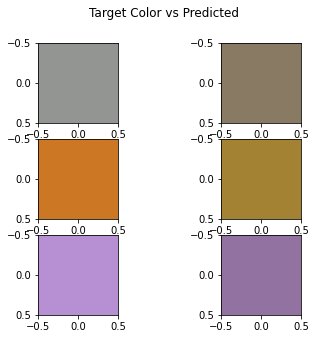

  5%|▌         | 1/20 [00:01<00:26,  1.38s/it]

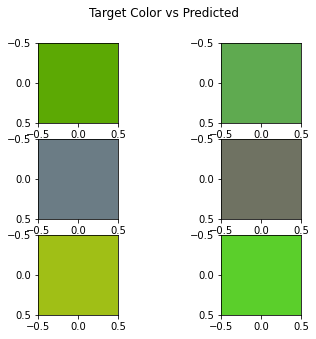

 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

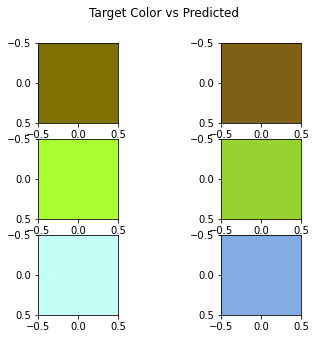

 15%|█▌        | 3/20 [00:02<00:15,  1.09it/s]

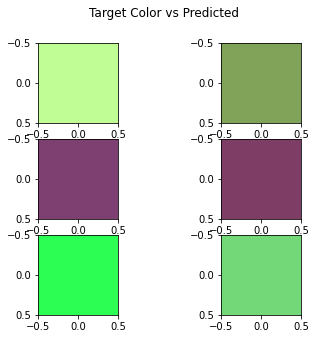

 20%|██        | 4/20 [00:03<00:13,  1.21it/s]

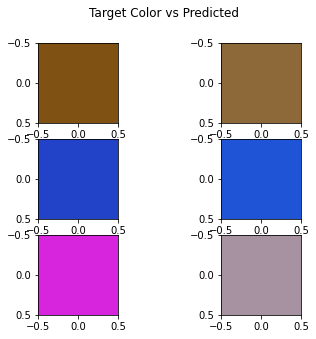

 25%|██▌       | 5/20 [00:05<00:16,  1.12s/it]

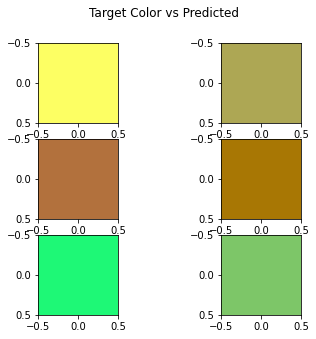

 30%|███       | 6/20 [00:06<00:15,  1.07s/it]

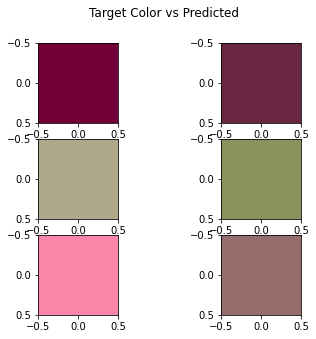

 35%|███▌      | 7/20 [00:06<00:12,  1.05it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


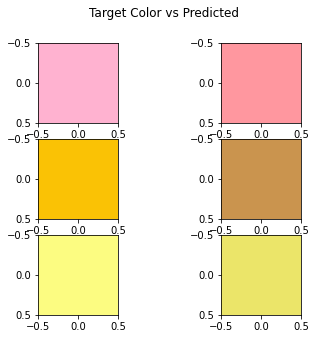

 40%|████      | 8/20 [00:07<00:10,  1.19it/s]

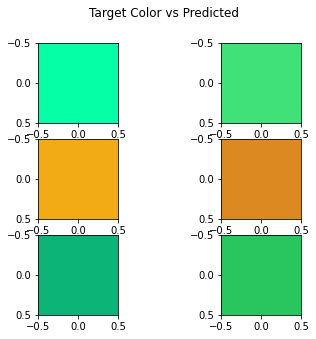

 45%|████▌     | 9/20 [00:08<00:08,  1.33it/s]

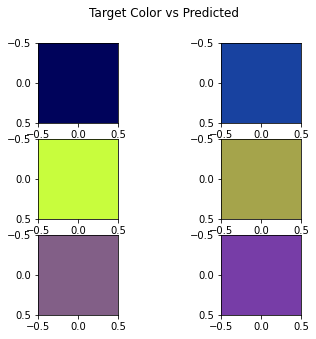

 50%|█████     | 10/20 [00:08<00:07,  1.43it/s]

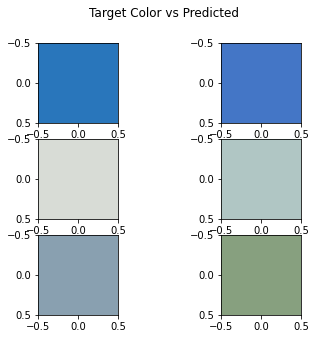

 55%|█████▌    | 11/20 [00:09<00:05,  1.51it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


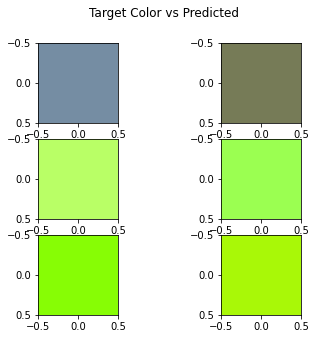

 60%|██████    | 12/20 [00:09<00:05,  1.55it/s]

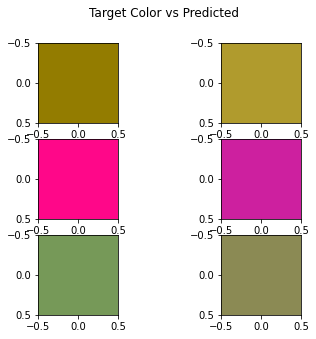

 65%|██████▌   | 13/20 [00:10<00:04,  1.60it/s]

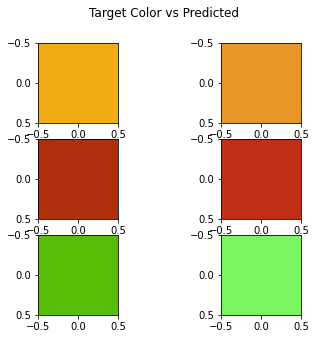

 70%|███████   | 14/20 [00:11<00:03,  1.51it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


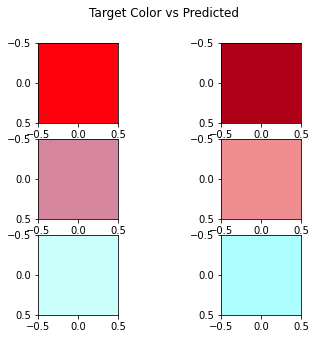

 75%|███████▌  | 15/20 [00:11<00:03,  1.55it/s]

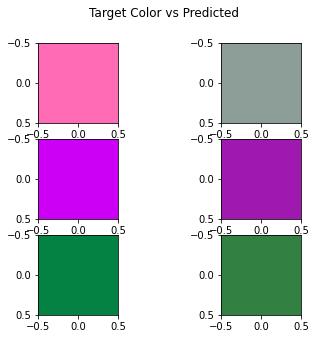

 80%|████████  | 16/20 [00:12<00:02,  1.62it/s]

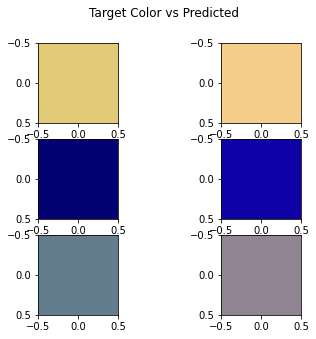

 85%|████████▌ | 17/20 [00:13<00:01,  1.63it/s]

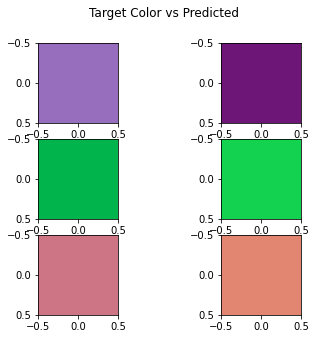

 90%|█████████ | 18/20 [00:13<00:01,  1.67it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


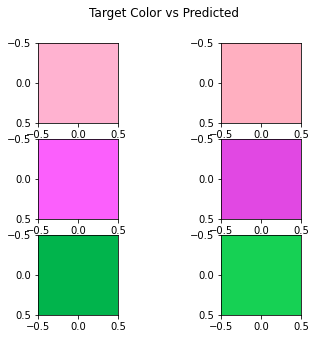

 95%|█████████▌| 19/20 [00:14<00:00,  1.69it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


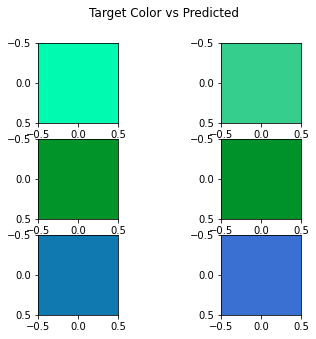

100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


In [20]:
# if we want to pretrain the weakly supervised rgb encoder (text to rgb), do so

if rgb_supervise and rgb_pred_pretrain_epochs:
    rgb_dataloader = DataLoader(
        rgb_dataset, 
        batch_size=batch_size, shuffle=True)
    print('pretraining rgb')
    rgb_optimizer = torch.optim.Adam(rgb_maker.parameters(), lr=lr)
    for epoch in tqdm(range(1, rgb_pred_pretrain_epochs+1)):
        # train rgb model
        for _, latent, rgb, _ in rgb_dataloader:
            rgb_optimizer.zero_grad()
            pred_rgb = rgb_maker(latent)
            loss = mse_loss(pred_rgb, rgb)
            loss.backward()
            rgb_optimizer.step()
        
        with torch.no_grad():
            # display some colors
            rand_color_idxs = np.random.randint(len(valid_color_rgb), size=num_displays)
            rand_colors = valid_color_rgb[rand_color_idxs].cpu().numpy()

            rand_color_features = valid_meta[rand_color_idxs].to(device)
            pred_rgb = rgb_maker(rand_color_features)

            fig, axes = plt.subplots(num_displays, 2)
            fig.suptitle('Target Color vs Predicted')
            fig.set_size_inches(6, 5)
            for j, ax in enumerate(axes):
                ax[0].imshow(rand_colors[j][None, None, :])
                ax[1].imshow(pred_rgb[j].cpu().numpy()[None, None, :])
            plt.show()

setting weakly supervised temperature to 0.98


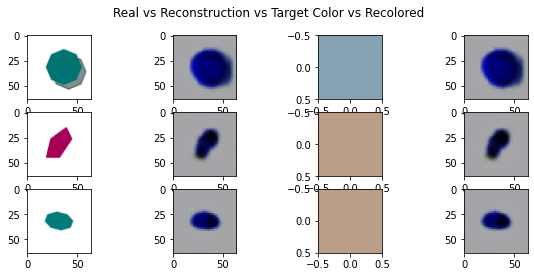

Epoch 2:  16%|█▌        | 45/282 [00:16<02:03,  1.92it/s]

In [ ]:
train_losses, valid_losses = [], []

rgb_losses, adversary_losses = [], []

update_idxs = set([i * (num_batches // updates_per_epoch)
    for i in range(1, updates_per_epoch)] + [num_batches])

best_valid = 1e9
for epoch in range(1, 1+num_epochs):
    total_loss = 0.0 

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=False, total=num_batches)
    
    if adversarial_supervise and adversarial_extra_train:
        adversary_extra_loader = iter(train_dataloader)
    
    for idx, (x, latent_supervision, rgb, has_rgb) in enumerate(pbar, start=1):
        
        # extra training runs for adversary
        if adversarial_supervise and adversarial_extra_train:
            for _ in range(adversarial_extra_train):
                batch = next(adversary_extra_loader, None)
                if batch is None:
                    adversary_extra_loader = iter(train_dataloader)
                    batch = next(adversary_extra_loader, None)
                
                x2, latent_supervision2, rgb2, has_rgb2 = batch
                
                if extra_reducer:
                    latent_supervision2 = reducer(latent_supervision2)
                    
                with torch.no_grad():
                    supervision = latent_supervision2
                    if rgb_supervise:
                        # just need the shape to match: z is not directly dependent on rgb2
                        supervision = rgb2
                    recon, mu, var, z = net(x2, supervision)
                    
                adv_optimizer.zero_grad()
                pred_target = adversary(z.detach())
                loss = adversarial_lambda * mse_loss(pred_target, 
                            latent_supervision2 if adversarial_target_language else rgb2)
                loss.backward()
                adv_optimizer.step()
        
        # main train loop
        optimizer.zero_grad()
        
        if extra_reducer:
            latent_supervision = reducer(latent_supervision)
            
        supervision = latent_supervision
        loss = 0.0
        if rgb_supervise:
            pred_rgb = rgb_maker(latent_supervision)
            
            # penalize if predicted rgb is wrong
            
            loss = loss + rgb_lambda * mse_loss(has_rgb * pred_rgb + (
                ~has_rgb) * rgb, rgb)
            
            if epoch < rgb_supervise_start_epoch:
                supervision = has_rgb * rgb + (~has_rgb) * pred_rgb
            else:
                supervision = pred_rgb
#             supervision = rgb if epoch < rgb_supervise_start_epoch else pred_rgb
        
        recon, mu, var, z = net(x, supervision)
        try:
            loss += vae_loss(x, mu, var, recon, beta)
        except:
            print(x.max())
            print(recon.max())
        
        if adversarial_supervise:
            pred_target = adversary(GRL(z))
            loss = loss + adversarial_lambda * mse_loss(pred_target, 
                            latent_supervision if adversarial_target_language else rgb)

        total_loss += loss.item() / gradient_accumulation_steps
        loss = loss / gradient_accumulation_steps
        loss.backward()
        optimizer.step()

        if idx in update_idxs:
            avg_valid_loss = 0.0
            
            avg_adversary_loss, avg_rgb_loss = 0.0, 0.0
            
            displays = []
            net.eval()
            with torch.no_grad():
                for (x, latent_supervision, rgb, _) in valid_dataloader:
                    
                    if extra_reducer:
                        latent_supervision = reducer(latent_supervision)
                        
                    supervision = latent_supervision
                    
                    if rgb_supervise:
                        pred_rgb = rgb_maker(latent_supervision)
                        avg_rgb_loss += mse_loss(pred_rgb, rgb).item() / num_valid_batches
                        supervision = pred_rgb
                        
                    recon, mu, var, z = net(x, supervision)
                    
                    if adversarial_supervise:
                        avg_adversary_loss += mse_loss(adversary(z), 
                        latent_supervision if adversarial_target_language else rgb).item() / num_valid_batches
                    
                    avg_valid_loss += vae_loss(x, mu, var, recon, beta).item() / num_valid_batches
                    if not displays:
                        net.random_z = tuple(z[0].detach().cpu().numpy())
                        
                        rand_color_idxs = np.random.randint(len(valid_color_rgb), size=num_displays)
                        rand_colors = valid_color_rgb[rand_color_idxs].cpu().numpy()
                        
                        rand_color_features = valid_meta[rand_color_idxs].to(device)
                        if extra_reducer:
                            rand_color_features = reducer(rand_color_features)
                        
                        if rgb_supervise:
                            rand_color_features = rgb_maker(rand_color_features)
                        
                        recon2 = net.generate(z[:num_displays], rand_color_features)
                        
                        for j in range(num_displays):
                            displays.append((
                                x[j].permute(1, 2, 0).cpu().numpy(),
                                recon[j].permute(1, 2, 0).cpu().numpy(),
                                rand_colors[j][None, None, :],
                                recon2[j].permute(1, 2, 0).cpu().numpy()
                            )
                            )
                
                if avg_valid_loss < best_valid:
#                     torch.save(net, f'models/{beta}-featurevae-{z_dim}dim')
#                     curr_metrics = []
#                     curr_color_metrics = []
#                     for (x, latent_supervision, rgb, _) in valid_dataloader:
#                         if extra_reducer:
#                             latent_supervision = reducer(latent_supervision)

#                         supervision = latent_supervision

#                         if rgb_supervise:
#                             pred_rgb = rgb_maker(latent_supervision)
#                             avg_rgb_loss += mse_loss(pred_rgb, rgb).item() / num_valid_batches
#                             supervision = pred_rgb

#                         recon, mu, var, z = net(x, supervision)

#                         rand_color_idxs = np.random.randint(len(valid_color_rgb), size=x.shape[0])
#                         rand_colors = valid_color_rgb[rand_color_idxs].cpu().numpy()

#                         rand_color_features = valid_meta[rand_color_idxs].to(device)
#                         if extra_reducer:
#                             rand_color_features = reducer(rand_color_features)

#                         if rgb_supervise:
#                             rand_color_features = rgb_maker(rand_color_features)

#                         recon2 = net.generate(z, rand_color_features)
#                         curr_metrics.extend([
#                             metricx(pilable(r), pilable(xi))
#                             for r, xi in zip(recon, x)
#                         ])
#                         curr_color_metrics.extend([
#                             colormetricx(pilable(r), colorable(c))
#                             for r, c in zip(recon2, rand_colors)
#                         ])
                        
                    best_valid = avg_valid_loss
                    
                valid_losses.append(avg_valid_loss)
                rgb_losses.append(avg_rgb_loss)
                adversary_losses.append(avg_adversary_loss)
            
            net.train()


            pbar.set_description(f"Epoch {epoch} | train loss {total_loss / idx:.2f}" + \
                                f" | valid loss {avg_valid_loss:.2f}")
            train_losses.append(total_loss / idx)
    
    if rgb_supervise and rgb_temp_beta:
        new_temp = get_temp() * rgb_temp_beta
        print('setting weakly supervised temperature to', new_temp)
        set_temp(new_temp)
    
    fig, axes = plt.subplots(num_displays, 4)
    fig.suptitle('Real vs Reconstruction vs Target Color vs Recolored')
    fig.set_size_inches(10, 4)
    for ax, im in zip(axes, displays):
        for axi, imi in zip(ax, im):
            axi.imshow(imi)
    plt.show()

In [ ]:
# trial['img_metric_mean'] = np.mean(curr_metrics, axis=0)
# trial['img_metric_std'] = np.std(curr_metrics, axis=0)

# trial['color_metric_mean'] = np.mean(curr_color_metrics)
# trial['color_metric_std'] = np.std(curr_color_metrics)

In [ ]:
# plt.plot(train_losses, label='Train Loss')
# plt.plot(valid_losses, label='Valid Loss')

# plt.legend()
# plt.show()

# if rgb_supervise:
#     plt.plot(rgb_losses, label='RGB Valid Loss')
#     plt.legend()
#     plt.show()
    
# if adversarial_supervise:
#     plt.plot(adversary_losses, label='Adversary Valid Loss')
#     plt.legend()
#     plt.show()